In [26]:
%load_ext autoreload
%autoreload 2

import warnings

import matplotlib.pyplot as plt
import seaborn as sns
import torch
from data_loader import load_mefisto_microbiome

from famo.core import CORE
from famo.plotting import (
    plot_all_weights,
    plot_training_curve,
    plot_variance_explained,
)

warnings.simplefilter(action="ignore", category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load mouse development data
data = load_mefisto_microbiome()

In [4]:
# Run model with MuData object
model = CORE(device="cuda")
model.fit(
    n_factors=2,
    data=data,
    likelihoods={"microbiome": "Normal"},
    factor_prior="GP",
    weight_prior="ARD_Spike_and_Slab",
    covariates_obs_key="month",
    lr=0.005,
    early_stopper_patience=500,
    print_every=100,
    center_groups=True,
    scale_views=False,
    scale_groups=True,
    max_epochs=10000,
    save=True,
    save_path="trained_model",
    init_factors="random",
    init_scale=0.1,
)

Setting up device...
- No device id given. Using default device: 0
- Running all computations on `cuda:0`
Fitting model...
- Checking compatibility of provided likelihoods with data.
  - microbiome: Normal
- Centering group_1/microbiome...


alt.Chart(...)

Initializing factors using `random` method...
{'microbiome': 1.0}
Decaying learning rate over 10000 iterations.
Setting training seed to `2408221605`.
Cleaning parameter store.
Epoch:       0 | Time:       1.06s | Loss:     103.81
Epoch:     100 | Time:       3.18s | Loss:      73.96
Epoch:     200 | Time:       5.15s | Loss:      71.52
Epoch:     300 | Time:       7.15s | Loss:      68.80
Epoch:     400 | Time:       9.29s | Loss:      67.99
Epoch:     500 | Time:      11.31s | Loss:      66.88
Epoch:     600 | Time:      13.46s | Loss:      67.22
Epoch:     700 | Time:      15.43s | Loss:      67.47
Epoch:     800 | Time:      17.45s | Loss:      66.48
Epoch:     900 | Time:      19.49s | Loss:      67.00
Epoch:    1000 | Time:      21.47s | Loss:      66.38
Epoch:    1100 | Time:      23.44s | Loss:      65.99
Epoch:    1200 | Time:      25.42s | Loss:      66.33
Epoch:    1300 | Time:      27.39s | Loss:      66.04
Epoch:    1400 | Time:      29.39s | Loss:      66.01
Epoch:    150

In [5]:
plot_training_curve(model)

alt.Chart(...)

In [6]:
plot_variance_explained(model)

alt.HConcatChart(...)

In [20]:
plot_all_weights(model)

alt.HConcatChart(...)

In [24]:
z = model.get_factors()
obs = model.data['group_1']['microbiome'].obs
obs['factor_1'] = z["group_1"].iloc[:, 0]
obs['factor_2'] = z["group_1"].iloc[:, 1]

<Axes: xlabel='month', ylabel='factor_2'>

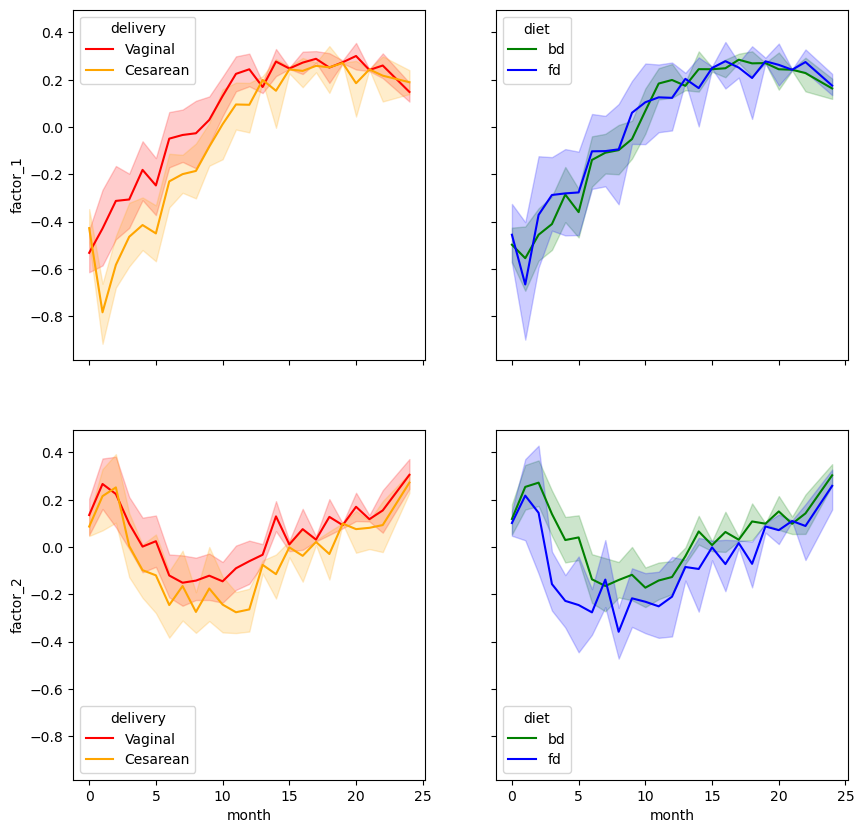

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)

sns.lineplot(obs, x='month', y='factor_1', hue='delivery', palette=["red", "orange"], ax=axs[0, 0])
sns.lineplot(obs, x='month', y='factor_2', hue='delivery', palette=["red", "orange"], ax=axs[1, 0])
sns.lineplot(obs, x='month', y='factor_1', hue='diet', palette=["green", "blue"], ax=axs[0, 1])
sns.lineplot(obs, x='month', y='factor_2', hue='diet', palette=["green", "blue"], ax=axs[1, 1])

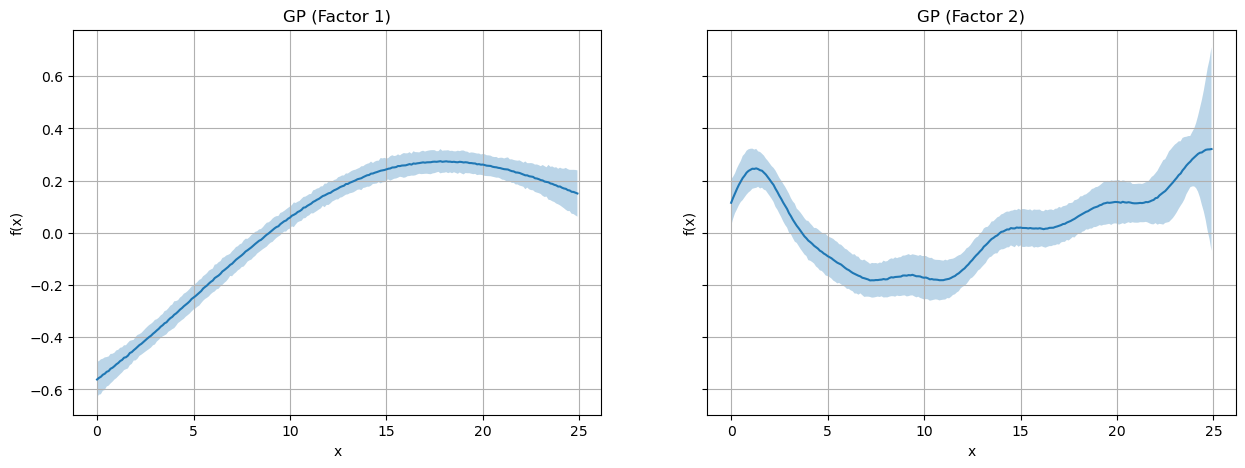

In [35]:
fig, axs = plt.subplots(1, model.n_factors, figsize=(15, 5), sharex=True, sharey=True)

x = torch.arange(0, 25, 0.1)
gp = model.gps["group_1"]
samples = gp(x.to(model.device), prior=False).sample(torch.Size([100]))
mean = samples.mean(axis=0).cpu().detach().numpy()
std = samples.std(axis=0).cpu().detach().numpy()
lower_bound = mean - 1.96 * std
upper_bound = mean + 1.96 * std

for factor in range(model.n_factors):
    ax = axs[factor]
    ax.plot(x, mean[factor], label=f"Factor {factor}")
    ax.fill_between(x, lower_bound[factor], upper_bound[factor], alpha=0.3)
    ax.set_title(f"GP (Factor {factor+1})")
    ax.set_xlabel("x")
    ax.set_ylabel("f(x)")
    ax.grid()